In [22]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import nn
import torch
import torch.nn.functional as FF
from pytorch_forecasting import TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping
import lightning.pytorch as pl

# 1. Data Preparation

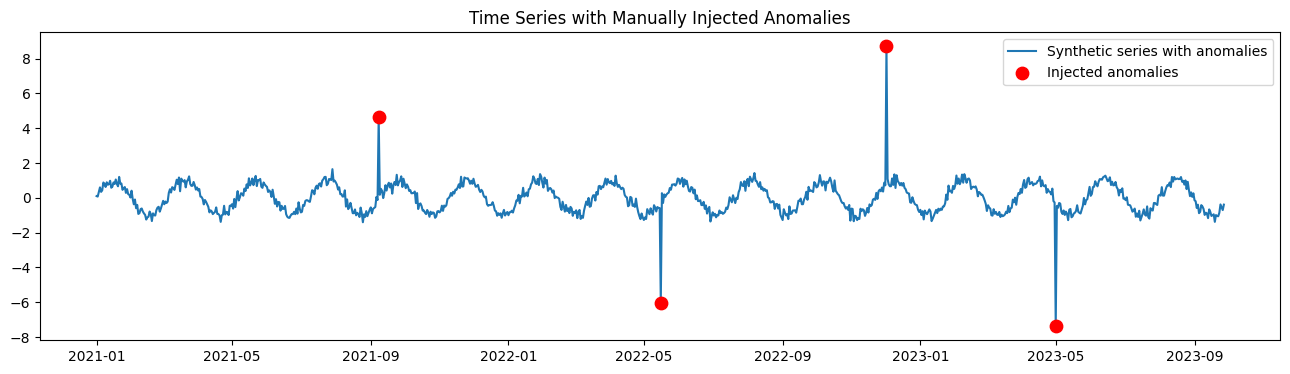

In [23]:

N_LAGS = 96
np.random.seed(42)

series = pd.DataFrame({
    "ds": pd.date_range("2021-01-01", periods=1000, freq="D"),
    "y": np.sin(np.linspace(0, 100, 1000)) + 0.2 * np.random.randn(1000)
})

# Inject anomalies: Add large spikes and drops at selected indices
anomaly_indices = [250, 500, 700, 850]
anomaly_magnitudes = [5, -6, 8, -7]  # Example spike/drop values

for idx, mag in zip(anomaly_indices, anomaly_magnitudes):
    series.loc[series.index[idx], "y"] += mag

series = series.set_index("ds")

# Visualize anomalies
plt.figure(figsize=(16, 4))
plt.plot(series.index, series["y"], label="Synthetic series with anomalies")
plt.scatter(series.index[anomaly_indices], series["y"].iloc[anomaly_indices], 
            color="red", label="Injected anomalies", zorder=5, s=80)
plt.legend()
plt.title("Time Series with Manually Injected Anomalies")
plt.show()


In [24]:
# Create rolling window data
def create_sequences(values, window):
    seqs = []
    for i in range(len(values) - window):
        seqs.append(values[i:i+window])
    return np.stack(seqs)

X = create_sequences(series["y"].values, N_LAGS)
X = torch.tensor(X, dtype=torch.float32)

# Simple train/val split
split = int(0.8 * len(X))
X_train = X[:split]
X_val = X[split:]


In [25]:
X

tensor([[ 0.0993,  0.0723,  0.3284,  ...,  0.0497, -0.0631, -0.3773],
        [ 0.0723,  0.3284,  0.6004,  ..., -0.0631, -0.3773, -0.1246],
        [ 0.3284,  0.6004,  0.3430,  ..., -0.3773, -0.1246, -0.2289],
        ...,
        [ 0.7145,  0.7341,  0.9119,  ..., -1.0584, -0.8587, -0.3792],
        [ 0.7341,  0.9119,  0.6157,  ..., -0.8587, -0.3792, -0.5396],
        [ 0.9119,  0.6157,  0.5023,  ..., -0.3792, -0.5396, -0.7042]])

# 2. LSTM Autoencoder Model
“Sequence to Sequence Learning with Neural Networks” (Sutskever et al., 2014) uses 256, 512, or 1024, but these are for very large datasets—64/32/16 are practical for moderate data.

Keras LSTM Autoencoder examples often use 32, 64, 128, or 256 as hidden sizes.

In [26]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features,  hidden_dim1= 128, hidden_dim2= 32):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim1,
            num_layers=1,
            batch_first=True,
        )
        self.encoder2 = nn.LSTM(
            input_size=self.hidden_dim1,
            hidden_size=self.hidden_dim2,
            num_layers=1,
            batch_first=True,
        )
        self.decoder1 = nn.LSTM(
            input_size=self.hidden_dim2,
            hidden_size=self.hidden_dim2,
            num_layers=1,
            batch_first=True,
        )
        self.decoder2 = nn.LSTM(
            input_size=self.hidden_dim2,
            hidden_size=self.hidden_dim1,
            num_layers=1,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hidden_dim1, n_features)

    def forward(self, x):
        # x shape: [batch, seq_len]
        x = x.unsqueeze(-1)  # [batch, seq_len, 1]
        batch_size = x.shape[0]
        x, (_, _) = self.encoder(x)
        x, (hidden_n, _) = self.encoder2(x)
        # hidden_n: [1, batch, embedding_dim]
        x = hidden_n.repeat(self.seq_len, 1, 1).permute(1, 0, 2)  # [batch, seq_len, embedding_dim]
        x, (_, _) = self.decoder1(x)
        x, (_, _) = self.decoder2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim1))
        return self.output_layer(x).squeeze(-1)


# 3. Training Loop

How to interpret train/val loss, what does magnitude mean?


In [27]:
model = LSTMAutoencoder(seq_len=N_LAGS, n_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in torch.split(X_train, 64):
        optimizer.zero_grad()
        recon = model(batch)
        loss = FF.mse_loss(recon, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    train_loss /= len(X_train)
    
    model.eval()
    with torch.no_grad():
        recon = model(X_val)
        val_loss = FF.mse_loss(recon, X_val)
    print(f"Epoch {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Val loss: {val_loss.item():.4f}")


Epoch 1/10, Train loss: 0.7063, Val loss: 0.8691
Epoch 2/10, Train loss: 0.6989, Val loss: 0.8488
Epoch 3/10, Train loss: 0.6867, Val loss: 0.8496
Epoch 4/10, Train loss: 0.6856, Val loss: 0.8476
Epoch 5/10, Train loss: 0.6848, Val loss: 0.8481
Epoch 6/10, Train loss: 0.6847, Val loss: 0.8476
Epoch 7/10, Train loss: 0.6842, Val loss: 0.8473
Epoch 8/10, Train loss: 0.6840, Val loss: 0.8468
Epoch 9/10, Train loss: 0.6835, Val loss: 0.8453
Epoch 10/10, Train loss: 0.6748, Val loss: 0.8327


# 4. Anomaly Score Calculation

In [30]:
X.shape

torch.Size([904, 96])

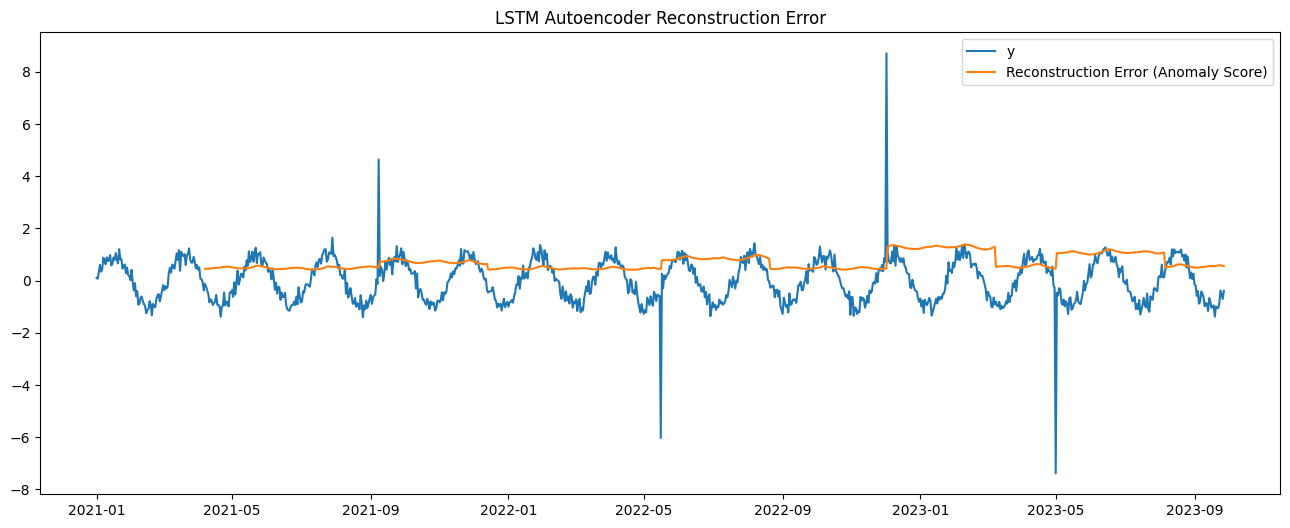

In [32]:
model.eval()
with torch.no_grad():
    recon_all = model(X)
    mse = ((recon_all - X) ** 2).mean(axis=1).cpu().numpy()

# Align anomaly score with time axis
anomaly_score = np.full(len(series), np.nan)
anomaly_score[N_LAGS:] = mse

plt.figure(figsize=(16, 6))
plt.plot(series.index, series["y"], label="y")
plt.plot(series.index, anomaly_score, label="Reconstruction Error (Anomaly Score)")
plt.legend()
plt.title("LSTM Autoencoder Reconstruction Error")
plt.show()


**What Does Each Anomaly Score Represent?**


The anomaly score at time t is based on how well the model can reconstruct the window that ends at time t.

A high score at time t suggests that the recent pattern (last N_LAGS points ending at t) was "unusual" for the model.

**How Should You Interpret the Plot?**
The blue curve: Your original time series.

The orange curve: The anomaly score (reconstruction error), aligned with the last point of each window.
The first N_LAGS points are NaN because the model doesn't have enough history to compute a score.

High anomaly score at t: Means the model could not accurately reconstruct the recent N_LAGS-length segment ending at t (possible anomaly).